# Debug linear join method

In [1]:
from spyral.core.point_cloud import PointCloud
from spyral.core.cluster import LabeledCloud
from spyral.core.clusterize import form_clusters, join_clusters, cleanup_clusters
from spyral.core.run_stacks import form_run_string
from spyral import ClusterParameters, OverlapJoinParameters, ContinuityJoinParameters, LinearJoinParameters

from pathlib import Path
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np

DEFAULT_COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

%matplotlib widget

# Utility for syncing plot colors
def get_color(value: int) -> str:
    color_index = value
    if color_index >= len(DEFAULT_COLORS):
        color_index = color_index % len(DEFAULT_COLORS)
    elif color_index == -1:
        return "black"
    return DEFAULT_COLORS[color_index]

# Some parameters
workspace_path = Path("/data/sustech/spyraline/")

params = ClusterParameters(
    min_cloud_size=50,
    min_points=5,
    min_size_scale_factor=0.0,
    min_size_lower_cutoff=5,
    cluster_selection_epsilon=5.0,
    overlap_join = None,
    continuity_join = None,
    linear_join = LinearJoinParameters(
        start_point_range = 40.0,
        position_threshold = 100.0,
        slope_threshold = 10.0,
    ),
    outlier_scale_factor=0.05,
)

# this may change if you add custom phases!
pointcloud_path = workspace_path / "Pointcloud"
run_number = 1030
point_file_path = pointcloud_path / f"{form_run_string(run_number)}.h5"
point_file = h5.File(point_file_path, 'r')

cloud_group: h5.Group = point_file.get('cloud')
min_event = cloud_group.attrs['min_event']
max_event = cloud_group.attrs['max_event']
event_iterator = iter(range(min_event, max_event+1))
print(f"First event: {min_event} Last event: {max_event}")

event = 8198
event_name = f"cloud_{event}"
if not event_name in cloud_group:
    raise Exception("This was a downscale beam event and has been removed from the analysis! Run this cell again to select a new event.")
event_data = cloud_group[f'cloud_{event}']
cloud = PointCloud(event, event_data[:].copy())
print(f'Cloud size: {len(cloud)}')
# Close any open plots to avoid memory problems

First event: 0 Last event: 39879
Cloud size: 1271


Total non-noise points: 0


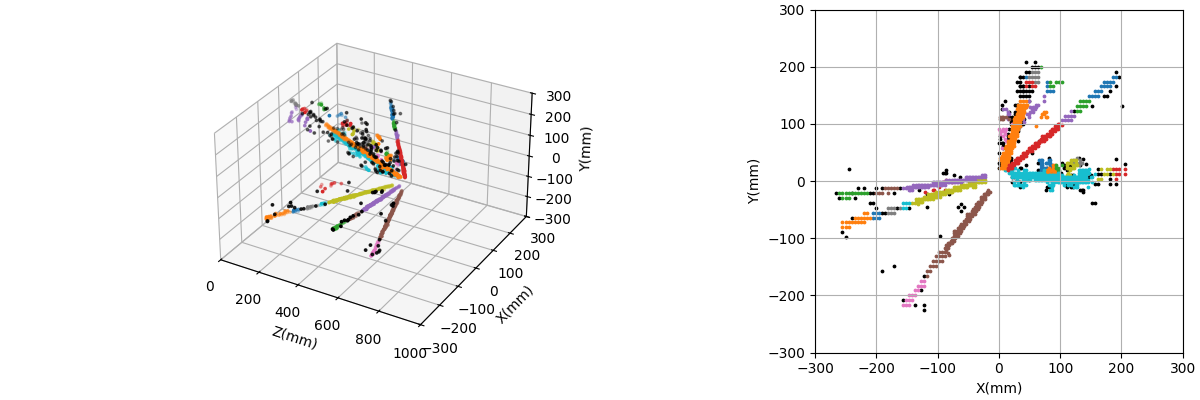

In [2]:
clusters, labels = form_clusters(cloud, params)
total_points = 0
print(f"Total non-noise points: {total_points}")
fig, axs = plt.subplot_mosaic(
    """
    AAB
    """,
    per_subplot_kw={
        "A": {
            "projection": "3d", 
            "box_aspect": (2,1,1),
            "aspect": "equalxy"
        }
    },
    figsize=(12.0, 4.0),
    constrained_layout=True
)

for cluster in clusters:
    axs["A"].scatter(cluster.point_cloud.data[:, 2], cluster.point_cloud.data[:, 0], cluster.point_cloud.data[:, 1], c=get_color(cluster.label), s=3, label=f"Cluster {cluster.label}")
    axs["B"].scatter(cluster.point_cloud.data[:, 0], cluster.point_cloud.data[:, 1], c=get_color(cluster.label), s=3, label=f"Cluster {cluster.label}")
axs["A"].set_xlim3d(0., 1000.0)
axs["A"].set_xlabel("Z(mm)")
axs["A"].set_ylim3d(-300.0, 300.0)
axs["A"].set_ylabel("X(mm)")
axs["A"].set_zlim3d(-300.0, 300.0)
axs["A"].set_zlabel("Y(mm)")
axs["B"].set_xlim(-300.0, 300.0)
axs["B"].set_xlabel("X(mm)")
axs["B"].set_ylim(-300.0, 300.0)
axs["B"].set_ylabel("Y(mm)")
axs["B"].grid()

35


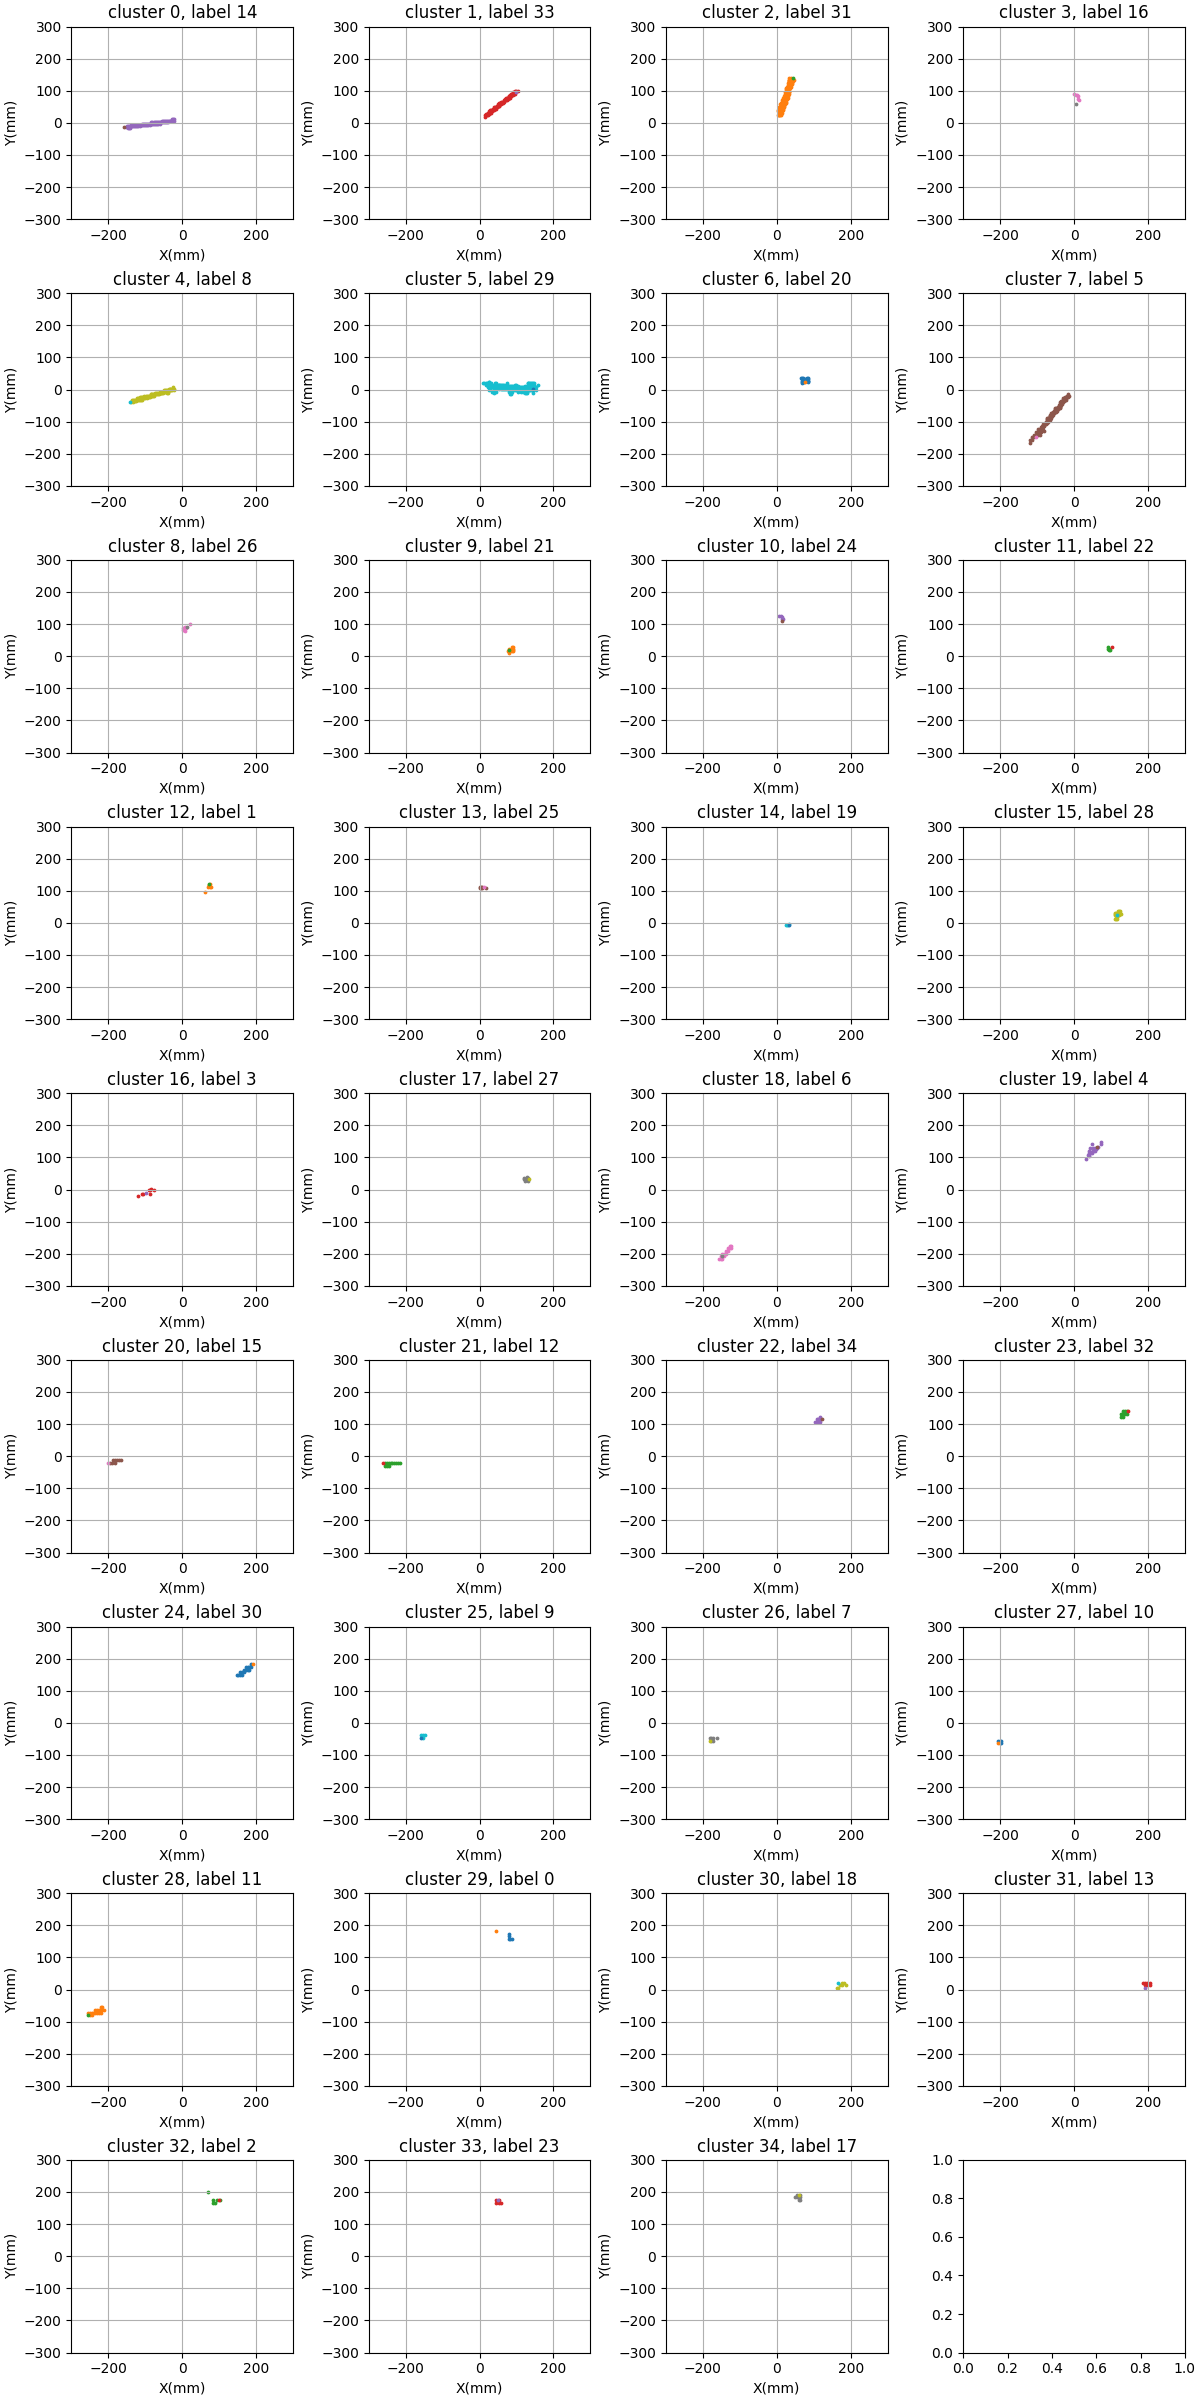

In [3]:
clusters, labels = form_clusters(cloud, params)
jclusters = [cluster for cluster in clusters if cluster.label != -1]
jclusters = sorted(
    jclusters,
    key=lambda x: x.point_cloud.data[-1, 6]
    * np.mean(x.point_cloud.data[:, 7]),
)
print(len(jclusters))
fig, axs = plt.subplots(9, 4, figsize=(12, 24), constrained_layout=True)
for idx, cluster in enumerate(jclusters):
    ax = axs.flatten()[idx]
    ax.scatter(
        cluster.point_cloud.data[1:, 0],
        cluster.point_cloud.data[1:, 1],
        c=get_color(cluster.label),
        s=3,
        label=f"Cluster {cluster.label}"
    )
    ax.scatter(
        cluster.point_cloud.data[0, 0],
        cluster.point_cloud.data[0, 1],
        c=get_color(cluster.label+1),
        s=3
    )
    ax.set_xlim(-300.0, 300.0)
    ax.set_xlabel("X(mm)")
    ax.set_ylim(-300.0, 300.0)
    ax.set_ylabel("Y(mm)")
    ax.set_title(f"cluster {idx}, label {cluster.label}")
    ax.grid()

In [8]:
clusters, labels = form_clusters(cloud, params)
event_number = clusters[0].point_cloud.event_number
print(f"Number of clusters: {len(clusters)}")
jclusters = [cluster for cluster in clusters if cluster.label != -1]
jclusters = sorted(
    jclusters,
    key=lambda x: x.point_cloud.data[-1, 6]
    * np.mean(x.point_cloud.data[:, 7]),
)

start_clusters = []
starter_xz_fit: dict[int, np.ndarray] = {}
starter_yz_fit: dict[int, np.ndarray] = {}
cluster_parent = []
for cluster in jclusters:
    cluster_parent.append(-1)

for idx, cluster in enumerate(jclusters):
    if cluster.label == -1:
        continue
    start_xy = np.sqrt(
        cluster.point_cloud.data[-1, 0]**2
        + cluster.point_cloud.data[-1, 1]**2
    )
    if (
        start_xy < params.linear_join.start_point_range
        and idx not in start_clusters
    ):
        start_clusters.append(idx)
        # fit line
        starter_xz_fit[idx] = np.polyfit(
            cluster.point_cloud.data[:, 2],
            cluster.point_cloud.data[:, 0],
            1
        )
        starter_yz_fit[idx] = np.polyfit(
            cluster.point_cloud.data[:, 2],
            cluster.point_cloud.data[:, 1],
            1
        )
    min_pos_diff = params.linear_join.position_threshold
    # get the tail
    tail_pos = np.median(cluster.point_cloud.data[:3, :3], axis=0)
    for cidx, compare_cluster in enumerate(jclusters):
        if compare_cluster.label == -1 or idx == cidx or cluster_parent[cidx] != -1:
            continue
        compare_start_xy = np.sqrt(
            compare_cluster.point_cloud.data[-1, 0]**2
            + compare_cluster.point_cloud.data[-1, 1]**2
        )
        if compare_start_xy < params.linear_join.start_point_range:
            continue
        compare_head_pos = np.median(
            compare_cluster.point_cloud.data[-3:, :3], axis=0
        )
        # check position distance
        pos_diff = np.linalg.norm(tail_pos - compare_head_pos)
        if (
            pos_diff > params.linear_join.position_threshold
            or pos_diff > min_pos_diff
        ):
            continue
        min_pos_diff = pos_diff
        # print(f"idx: {idx}, cidx: {cidx}, pos_diff: {pos_diff}")
        # check slope point
        starter_idx = idx
        while cluster_parent[starter_idx] != -1:
            starter_idx = cluster_parent[starter_idx]
        if starter_idx not in start_clusters:
            continue
        compare_mean = np.mean(compare_cluster.point_cloud.data[:, :3], axis=0)
        slope_point_x = (
            starter_xz_fit[starter_idx][0] * compare_mean[2]
            + starter_xz_fit[starter_idx][1] - compare_mean[0]
        )
        slope_point_y = (
            starter_yz_fit[starter_idx][0] * compare_mean[2]
            + starter_yz_fit[starter_idx][1] - compare_mean[1]
        )
        # print(f"spx: {slope_point_x}, spy: {slope_point_y}")
        if (
            slope_point_x > params.linear_join.slope_threshold
            or slope_point_y > params.linear_join.slope_threshold
        ):
            continue
        # join cluster
        cluster_parent[cidx] = idx
        for index, pidx in enumerate(cluster_parent):
            if pidx == idx:
                cluster_parent[index] = -1
        # print(f"Join {cidx} to {idx}")


print(start_clusters)
# print(starter_xz_fit)
# print(starter_yz_fit)
for index, pindex in enumerate(cluster_parent):
    if pindex != -1:
        print(f"{index} -> {pindex}")
for idx in start_clusters:
    print(f"{idx}: {jclusters[idx].point_cloud.data.shape[0]}")

# Now reform the clouds such that there is one cloud per group
new_clusters: list[LabeledCloud] = []
update = [False] * len(cluster_parent)
cluster_map: dict[int, int] = {}
count = 100
while not all(update):
    if count == 0:
        break
    count -= 1
    old = []
    for idx, value in enumerate(update):
        if not value:
            old.append(idx)
    print(old)
    for idx in range(len(cluster_parent)):
        if update[idx]:
            continue
        if cluster_parent[idx] == -1:
            new_cluster = LabeledCloud(
                jclusters[idx].label,
                PointCloud(
                    event_number,
                    jclusters[idx].point_cloud.data.copy()
                ),
                jclusters[idx].parent_indicies.copy()
            )
            cluster_map[idx] = len(new_clusters)
            new_clusters.append(new_cluster)
            update[idx] = True
            # print(f"Put {idx} in slot {len(new_clusters)-1}")
        else:
            pidx = cluster_parent[idx]
            while cluster_parent[pidx] != -1:
                pidx = cluster_parent[pidx]
            slot = cluster_map[pidx]
            new_clusters[slot].point_cloud.data = np.concatenate(
                (
                    new_clusters[slot].point_cloud.data,
                    jclusters[idx].point_cloud.data
                ), axis=0
            )
            new_clusters[slot].parent_indicies = np.concatenate(
                (
                    new_clusters[slot].parent_indicies,
                    jclusters[idx].parent_indicies
                ), axis=0
            )
            update[idx] = True
            # print(f"Put {idx} in slot {slot}")

print(len(new_clusters))
# print(cluster_map)
for idx in start_clusters:
    print(f"{idx}: {new_clusters[cluster_map[idx]].point_cloud.data.shape[0]}")

# sort
for cluster in new_clusters:
    indicies = np.argsort(cluster.point_cloud.data[:, 2])
    cluster.point_cloud.data = cluster.point_cloud.data[indicies]
    cluster.parent_indicies = cluster.parent_indicies[indicies]

new_labels = labels
for idx in range(len(cluster_parent)):
    pidx = cluster_parent[idx]
    if idx == -1:
        continue
    while cluster_parent[pidx] != -1:
        pidx = cluster_parent[pidx]
    new_labels[labels == jclusters[idx].label] = jclusters[pidx].label


Number of clusters: 36
[0, 1, 2, 4, 5, 7, 14]
0: 92
1: 83
2: 147
4: 103
5: 228
7: 117
14: 5
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
35
0: 92
1: 83
2: 147
4: 103
5: 228
7: 117
14: 5


In [9]:
clusters, labels = form_clusters(cloud, params)
joined_clusters, labels = join_clusters(clusters, params, labels)
fig, axs = plt.subplot_mosaic(
    """
    AAB
    """,
    per_subplot_kw={
        "A": {
            "projection": "3d", 
            "box_aspect": (2,1,1),
            "aspect": "equalxy"
        }
    },
    figsize=(12.0, 4.0),
    constrained_layout=True
)

for cluster in joined_clusters:
    axs["A"].scatter(cluster.point_cloud.data[:, 2], cluster.point_cloud.data[:, 0], cluster.point_cloud.data[:, 1], c=get_color(cluster.label), s=3, label=f"Cluster {cluster.label}")
    axs["B"].scatter(cluster.point_cloud.data[:, 0], cluster.point_cloud.data[:, 1], c=get_color(cluster.label), s=3, label=f"Cluster {cluster.label}")
axs["A"].set_xlim3d(0., 1000.0)
axs["A"].set_xlabel("Z(mm)")
axs["A"].set_ylim3d(-300.0, 300.0)
axs["A"].set_ylabel("X(mm)")
axs["A"].set_zlim3d(-300.0, 300.0)
axs["A"].set_zlabel("Y(mm)")
axs["B"].set_xlim(-300.0, 300.0)
axs["B"].set_xlabel("X(mm)")
axs["B"].set_ylim(-300.0, 300.0)
axs["B"].set_ylabel("Y(mm)")
axs["B"].grid()
# axs["A"].legend()

KeyboardInterrupt: 